# Import the relevant libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Import the dataset

In [2]:
DIR = "WasteImagesDataset/"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, 
                                                                    subset="training", seed=42, 
                                                                    batch_size=16, smart_resize=True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                  subset="validation", seed=42,
                                                                  batch_size=16, smart_resize=True)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Metal device set to: Apple M1
Found 5078 files belonging to 9 classes.
Using 507 files for validation.


2022-01-22 17:55:11.595829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-22 17:55:11.595979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Optimise the training and testing performance

In [3]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood'] 9


### Performing Data Augmentation

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# MODELS

### Basic CNN

In [5]:
# model = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),

#     tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(numClasses, activation='softmax')
# ])

### Inception V3 Model

In [6]:
# Inception_V3_Model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),
#                                              weights='imagenet',
#                                              include_top=False,
#                                              classes=numClasses)

# for layer in Inception_V3_Model.layers[:249]:
#     layer.trainable = False

# for layer in Inception_V3_Model.layers[249:]:
#     layer.trainable = True

# last_output = data_augmentation(Inception_V3_Model.output)
# maxpooled_output = tf.keras.layers.Flatten()(last_output)

# x = tf.keras.layers.Dense(1024, activation='relu')(maxpooled_output)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

# inception_model = tf.keras.Model(inputs=Inception_V3_Model.input, outputs=x)

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()

# inception_model.compile(optimizer=optimizer,
#                         loss=loss,
#                         metrics=['accuracy'])

# history = inception_model.fit(train_dataset, epochs=10)

### Resnet152 Model 

In [7]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False
    
last_output = baseModel.layers[-1].output

x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=10
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

Epoch 1/10


2022-01-22 17:55:15.601054: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-22 17:55:15.617291: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-22 17:55:15.617861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - ETA: 0s - loss: 0.9743 - accuracy: 0.7344

2022-01-22 17:58:47.133552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 240s 831ms/step - loss: 0.9743 - accuracy: 0.7344 - val_loss: 0.4411 - val_accuracy: 0.8501
Epoch 2/10
286/286 [==============================] - 250s 875ms/step - loss: 0.2092 - accuracy: 0.9293 - val_loss: 0.3595 - val_accuracy: 0.8876
Epoch 3/10
286/286 [==============================] - 254s 888ms/step - loss: 0.0985 - accuracy: 0.9687 - val_loss: 0.3852 - val_accuracy: 0.8974
Epoch 4/10
286/286 [==============================] - 251s 879ms/step - loss: 0.0636 - accuracy: 0.9788 - val_loss: 0.3841 - val_accuracy: 0.8955


### Model Evaluation

In [8]:
# plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
# plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
# plt.legend()
# plt.show()

In [9]:
# plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
# plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
# plt.legend()
# plt.show()

In [10]:
# plt.xlim([0, 0.003])
# learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
# plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
# plt.title('Learning rate vs. loss', size=20)
# plt.xlabel('Learning rate', size=14)
# plt.ylabel('Loss', size=14)

### MobileNetV3

In [11]:
# baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', 
#                                                    include_top=False, classes=numClasses)
# for layers in baseModel.layers[:-6]:
#   layers.trainable=False

# last_output = baseModel.layers[-1].output
# x = tf.keras.layers.Dropout(0.45) (last_output)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.BatchNormalization() (x)
# x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, 
#                           kernel_regularizer=tf.keras.regularizers.l1(0.045), 
#                           activity_regularizer=tf.keras.regularizers.l1(0.045),  
#                           kernel_initializer='he_normal')(x)
# x = tf.keras.layers.Dropout(0.45) (x)
# x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

# model = tf.keras.Model(inputs=baseModel.input,outputs=x)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=['accuracy'])

# epochs = 50
# lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
# stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
# callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
# history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

# Testing

2022-01-22 18:11:49.990220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[3.7686306e-04 6.8618362e-03 4.9296469e-09 5.1884797e-07 3.4355148e-07
 9.9776199e+01 8.3636451e-07 4.7372009e-07 2.1656701e-01] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Paper and Cardboard 99.77619647979736%


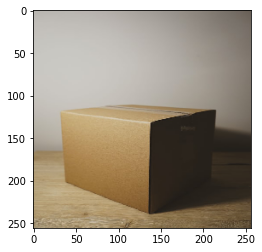

In [12]:
url = "https://images.unsplash.com/photo-1577705998148-6da4f3963bc8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Nnx8Y2FyZGJvYXJkfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"
image = tf.keras.utils.get_file("Image1.jpg", origin=url)

img = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
#score = tf.nn.softmax(predictions[0])

plt.imshow(img)
# print(predictions)
# print("Prediction: " + str(classes[np.argmax(predictions)]))
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

[2.3111986e-02 7.1516033e-04 1.8855692e-01 2.4329787e-03 9.9353493e+01
 3.1102604e-01 1.0386837e-01 1.6348640e-02 4.4064136e-04] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Other Plastics 99.35349225997925%


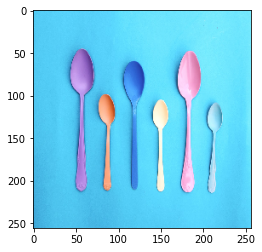

In [13]:
import requests

img_data = requests.get("https://images.unsplash.com/photo-1591872203534-278fc084969e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1064&q=80").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

# Confusion Matrix

<Figure size 720x720 with 0 Axes>

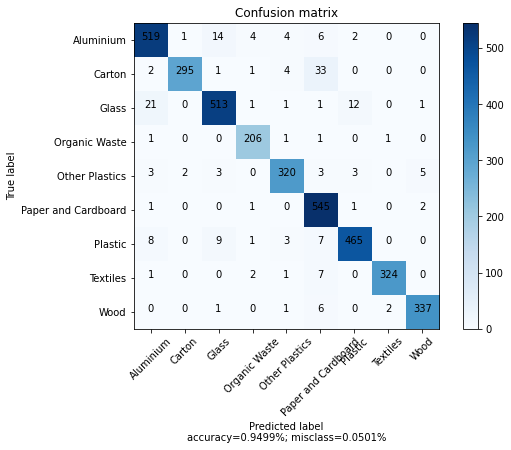

In [14]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "WasteImagesDataset/"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)